##### Joshua Fisher
##### Final Deliverable

#### Dataset & Business Use Case

> In the late 1990’s, the NHL started their initiative to track player and team statistics on a game-by-game basis. However, it was not until this past decade that sports analytics came into the forefront as a tool to measure player performance. Teams around the league have established analytics teams to track and model a multitude of stats in order evaluate what make a player good and therefore what wins hockey games. While the main goal is of course to win a Stanley Cup championship, the NHL is a business and thus focused on maximizing profits. In recent seasons, the NHL has made about 5 billion dollars in yearly revenue. Each team on average is valued at around 650 million dollars. The main production of revenue is driven by ticket sales and television contracts. More successful teams in larger markets are rewarded by more ticket sales and television primetime slots. Next season, the Seattle Kraken will be entering the league as the 32nd NHL team. With the expansion draft coming up, it is key that the team identifies who the key players are, for good players win hockey games and therefore increase revenue.  This will be achieved using a collection of NHL datasets that capture a season’s worth of game and player statistics. The repository can be found at: https://www.kaggle.com/martinellis/nhl-game-data

> Using techniques common to graph theory and network science, this use case will aim to answer the question: “Which players are most central to hockey games?” Answering this question will identify who the best players are in the league and provide the most value to their teams.  In doing so, the Seattle Kraken will be able to draft the best players available to win a Stanley Cup and optimize their organization. 

#### Data Model
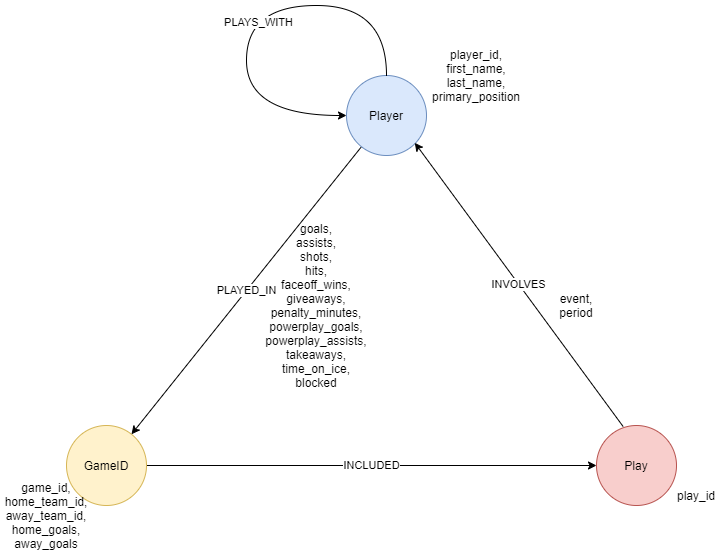

#### Projections

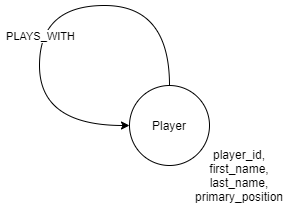


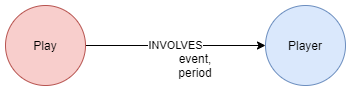

#### Populated Neo4J Database Screenshot

<img src="Populated Neo4J Database Pic.png">

### Cypher Queries

In [3]:
import pandas as pd

#### Cypher Query 1

MATCH (p:Player) <br>
WITH p, SIZE((p)<-[:PLAYS_WITH]-()) AS plays_with_degree <br>
RETURN p.first_name + ' ' + p.last_name AS name, plays_with_degree <br>
ORDER BY plays_with_degree DESC <br>

In [5]:
plays_with = pd.read_csv('Cyphers_Algorithms/Cypher1_result.csv')
plays_with.head()

,name,plays_with_degree
0,Ryan Getzlaf,159
1,Claude Giroux,153
2,Jordan Staal,136
3,Derek Grant,129
4,Adam Henrique,128


This first query gives insight into which players have the most interactions with other players. A player who is playing with more people means that they are central to a network and likely to be important. These are nodes/players that can help to understand how the player network is structured and how are significant players.

#### Cypher Query 2

MATCH (p:Player) <br>
WITH p, SIZE((p)<-[:INVOLVES]-()) as player_involvement <br>
RETURN p.first_name + ' ' + p.last_name, player_involvement <br>
ORDER BY player_involvement DESC <br>

In [7]:
player_involvement = pd.read_csv('Cyphers_Algorithms/Cypher2_result.csv')
player_involvement.head()

,name,player_involvement
0,Dylan Larkin,629
1,Patrice Bergeron,617
2,Bo Horvat,572
3,Mark Scheifele,571
4,Claude Giroux,570


Hockey players that are involved in more plays, thus contributing to the game, are believed to hold more value. Therefore, this query aimed to identify the players that were involved in the most plays. It returns first and last name of the player as well as the number of player involvements, defined by the number of degrees linked by an INVOLVES edge.


#### Cypher Query 3

MATCH (p:Player)-[n:INVOLVES]-() <br>
WHERE n.event IN ['Goal','Assist'] <br>
RETURN p.first_name + ' ' + p.last_name AS name, count(n.event) AS Degree <br>
ORDER BY Degree DESC

In [8]:
goals_assists_leaders = pd.read_csv('Cyphers_Algorithms/Cypher3_result.csv')
goals_assists_leaders.head()

,name,Degree
0,Leon Draisaitl,42
1,Connor McDavid,37
2,Brad Marchand,32
3,John Carlson,31
4,David Pastrnak,31


Goals and assists (which are indirectly goals) are the most valued stat in a hockey game. In order to win games, you need to score more goals than the opposing teams. This query returns players who were involved in the most plays in which the INVOLVES edge property was either a goal or an assist as well as the count of event that met that criteria. 

#### Cypher Query 4

MATCH (p1:Player)-[i1:INVOLVES]-(pl:Play)-[i2:INVOLVES]-(p2:Player) <br>
WHERE i1.event IN ['Faceoff'] AND  <br>
&emsp;&emsp;&emsp; i2.event IN ['Faceoff'] AND <br>
&emsp;&emsp;&emsp; id(p1) < id(p2)<br>
RETURN DISTINCT p1.first_name + ' ' + p1.last_name AS first_player, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; p2.first_name + ' ' + p2.last_name AS second_player, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; COUNT(pl) AS faceoffs_together_count <br>
ORDER BY faceoffs_together_count DESC <br>

In [9]:
faceoffs = pd.read_csv('Cyphers_Algorithms/Cypher4_faceoffs.csv')
faceoffs.head()

,first_player,second_player,faceoffs_together_count
0,Brock Nelson,Aleksander Barkov,29
1,Auston Matthews,Patrice Bergeron,27
2,Anthony Cirelli,Aleksander Barkov,25
3,Mark Scheifele,Sidney Crosby,25
4,Jack Eichel,Anthony Cirelli,22


Faceoffs are a major part of every hockey game. Simply put, winning a faceoffs gives your team posssesion of the puck. Possession of the puck is needed to score goals and thus win the game. Above is a query that finds the players that have engaged in the most faceoffs together. Using this knowledge in conjunction with the player statistics, advantageous matchups can be identified. For example, two players from above, Auston Matthews and Patrice Bergeron, both play in the Atlantic Division. If I can find that Patrice Bergeron wins 75% of faceoffs against Auston Matthews, the Boston coach should be aware that Bergeron is likely to win and so he should be put out on the ice when Auston Matthews is also on the ice. 

### Algorithm 1 - PageRank

#### Projection

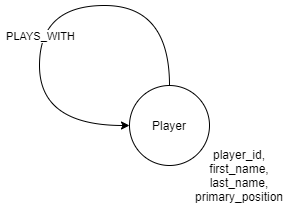

#### Code

CALL gds.graph.create.cypher('plays_with_graph', <br>
                     'MATCH (p:Player) RETURN id(p) as id', <br>
                     'MATCH (p1:Player)-[:PLAYS_WITH]-(p2:Player) RETURN id(p1) as source, id(p2) as target'); <br>
                     
CALL gds.pageRank.stream('plays_with_graph') YIELD nodeId, score <br>
RETURN gds.util.asNode(nodeId).first_name + ' ' + gds.util.asNode(nodeId).last_name AS name, score <br>
ORDER BY score DESC LIMIT 10 <br>

#### Results

In [10]:
pageRank = pd.read_csv('Cyphers_Algorithms/page_rank_results.csv')

In [15]:
pageRank.head()

,name,score
0,Ryan Getzlaf,1.983806
1,Radek Faksa,1.974747
2,Jordan Staal,1.921278
3,Lars Eller,1.920954
4,Claude Giroux,1.884007


#### Conclusions

The idea behind using the PageRank algorithm for this use case was it's ability to find which players are most important to the network. This algorithm models the probability that random hops across the network would lead you to a certain player. The higher the score the more prominent a player. The results above displays the top 10 players ranked by PageRank score. Here we can see that players Ryan Getzlaf, Radek Faksa, and Jordan Staal are some of the most important players to this network. Knowing this information, we can conclude that these are players that should be targeted by the Seattle Kraken for the expansion draft.

### Algorithm 2 - Betweenness Centrality

#### Projection

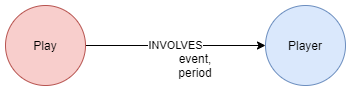

#### Code

CALL gds.graph.create.cypher('goal_assists', <br>
&emsp;&emsp;    'MATCH (p:Player) RETURN id(p) AS id', <br>
&emsp;&emsp;    'MATCH (p1:Player)-[i1:INVOLVES]-(pl:Play)-[i2:INVOLVES]-(p2:Player) <br>
&emsp;&emsp;     WHERE i1.event IN ["Goal","Assist"] AND i2.event IN ["Goal","Assist"] AND id(p1) < id(p2) <br>
&emsp;&emsp;     RETURN DISTINCT id(p1) AS source, id(p2) AS target'); <br>


CALL gds.betweenness.stream('goal_assists') YIELD nodeId, score <br>
RETURN gds.util.asNode(nodeId).first_name + ' ' + gds.util.asNode(nodeId).last_name AS name, score <br>
ORDER BY score DESC <br>

#### Results

In [17]:
betweenness = pd.read_csv('Cyphers_Algorithms/betweeness_results.csv')
betweenness.head()

,name,score
0,William Karlsson,30.866667
1,Filip Chlapik,27.333333
2,Radek Faksa,27.083333
3,Robby Fabbri,26.200000
4,Jared McCann,25.916667


#### Conclusions

Betweenness Centrality is typically used to find the people with most influence in a network. This algorithm gives insight into how much information a particular node has passed through it compared to other nodes. In this query, the idea was to identify players in which plays involved them. Goals and assists are the most valuable statistic in the game of hockey and therefore the plays were limited to these events. We can identify that players like William Karlsson are significantly important to this Goals + Assists network, meaning that he is highly involved in these plays. As such, he would be a prime candidate to target by the Seattle Kraken for the expansion draft. 

### Algorithm 3 - Modularity Optimization

#### Projection

Because the business case revolves around identifying who best players are, the same projection was used for this algorithm. The meat of this dataset lies in the relationship of who played with who. Therefore, the projection is the same:

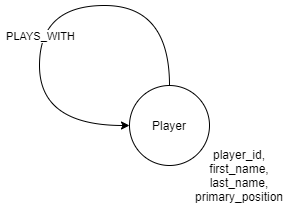

#### Code

CALL gds.graph.create.cypher('plays_with_graph', <br>
'MATCH (p:Player) RETURN id(p) as id', <br>
'MATCH (p1:Player)-[:PLAYS_WITH]-(p2:Player) RETURN id(p1) as source, id(p2) as target'); <br>


CALL gds.beta.modularityOptimization.stream('plays_with_graph') <br>
YIELD nodeId, communityId <br>
RETURN gds.util.asNode(nodeId).last_name as last_name, gds.util.asNode(nodeId).first_name as first_name, communityId <br>

#### Results

In [18]:
modularity = pd.read_csv('Cyphers_Algorithms/modularity_optimization.csv')

In [21]:
modularity.head()

,name,communityId
0,Shayne Gostisbehere,721
1,Claude Giroux,721
2,Travis Konecny,721
3,Ivan Provorov,721
4,Brandon Manning,416


#### Conclusions

The Modularity Optimization algorithm is a community detection technique used to find commmunities within a network. It is an extension of the Louvain algorithm. The modularity score evaluates the density and how well the groups have been assigned to their clusters or communities. The higher the modularity score, the more likely a node is to be long to that particular cluster. The idea behind using this algorithm for this use case lies in the fact that good players are most similar to other good players. So, if we are able to identify a "good player cluster" we can drill down to identify what players populate that cluster.  

The results above is a snippet of players and their communities that the algorithm assigned. Here we can see players who are similar to others. Using domain knowledge like knowing that "Claude Giroux" is a top player, we can deduce that players like "Travis Konecny" is also a good player.

### Algorithm 4 - Degree Centrality

#### Projection

Again because the most important information is accessed using the PLAYS_WITH relationship, the same projection was used:

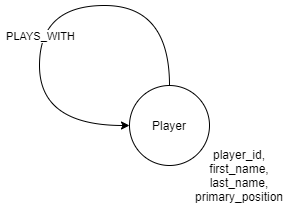

#### Code

CALL gds.graph.create.cypher('plays_with_graph', <br>
'MATCH (p:Player) RETURN id(p) as id', <br>
'MATCH (p1:Player)-[:PLAYS_WITH]-(p2:Player) RETURN id(p1) as source, id(p2) as target'); <br>


CALL gds.alpha.degree.stream('plays_with_graph') YIELD nodeId, score <br>
RETURN gds.util.asNode(nodeId).last_name As last_name, gds.util.asNode(nodeId).first_name AS first_name, score AS Degree <br>
ORDER BY score DESC

#### Results

In [22]:
degree = pd.read_csv('Cyphers_Algorithms/degree_centrality_results.csv')

In [25]:
degree.head()

,name,Degree
0,Ryan Getzlaf,163.0
1,Lars Eller,157.0
2,Jordan Staal,155.0
3,Claude Giroux,154.0
4,Radek Faksa,153.0


#### Conclusions

The degree centrality is a simple algorithm that is commonly used to find popular or important nodes. As such, this algorithm was applied to find the players who have the highest play degrees and thus involved in the most plays. Here was can see some re-occuring names from previous algorithm results like Ryan Getzlaf. This further supports that plays like him are valuable because of his high inter-connectedness. 

## Elective Graph ML

#### Model - GraphSAGE

After some further research by the Seattle Kraken's analytics department, the team has decided to try to implement some graph machine learning into their methods to characterize NHL players. One model of interest is the GraphSAGE model that works to embed player features into float vectors. Using player nodes and the PLAYS_WITH edge, the GraphSAGE will transform player attributes into a useable format for a ML classification model. The model will be trained based of player degree which has been calculated based on how my PLAYS_WITH edges a certain player has. Following training, the model will return the player and their associated embedding vector. 

#### Code

CALL gds.graph.create('Player_sage', <br>
&emsp;     { <br>
&emsp;&emsp;        Player: { <br>
&emsp;&emsp;&emsp;               label: 'Player', <br>
&emsp;&emsp;&emsp;               properties:['degree','pagerank','betweenness'] <br>
&emsp;&emsp;         } <br>
&emsp;&emsp;        }, { <br>
&emsp;&emsp;&emsp;                PLAYS_WITH: { <br>
&emsp;   type: 'PLAYS_WITH', <br>
&emsp;   orientation: 'UNDIRECTED'}}) <br>

CALL gds.beta.graphSage.train( <br>
&emsp;&emsp;  'Player_sage', <br>
&emsp;  { <br>
&emsp;&emsp;    modelName: 'graphSage', <br>
&emsp;&emsp;    featureProperties: ['degree','pagerank','betweenness'] <br>
&emsp;&emsp;    learningRate:0.001, <br>
&emsp;&emsp;    epochs:10 <br>
&emsp;  } <br>
)

CALL gds.beta.graphSage.stream( <br>
&emsp;&emsp;  'Player_sage', <br>
&emsp;  { <br>
&emsp;&emsp;    modelName: 'graphSage' <br>
&emsp;  }) <br>
YIELD nodeId, embedding <br>
RETURN gds.util.asNode(nodeId).first_name + ' ' + gds.util.asNode(nodeId).last_name AS Player, embedding <br>

In [1]:
import numpy as np
import ast
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
sage_results = pd.read_csv('Graph_ML/player_embeddings_updated.csv')
sage_results.head()

,Player,embedding
0,Shayne Gostisbehere,"[0.14700257843835648,0.09907323624766974,0.144..."
1,Claude Giroux,"[0.1470067904589967,0.09910921887735187,0.1440..."
2,Travis Konecny,"[0.147017925265184,0.0991130492455645,0.144033..."
3,Ivan Provorov,"[0.14703986514958733,0.0994014540162101,0.1442..."
4,Brandon Manning,"[0.1469074624022591,0.09948891659090621,0.1442..."


In [5]:
#the embedding vectors are being read in as a string representation of a list. Apply ast.literal_eval to convert to list
sage_results['embedding'] = sage_results['embedding'].apply(ast.literal_eval)

In [6]:
#expand each embedding element into its own column
embeddings = sage_results['embedding'].apply(pd.Series)
embeddings = embeddings.rename(columns = lambda x: 'embedding_' + str(x))

In [7]:
#concatentate the embedding columns with the original player names
concat_sage = pd.concat([sage_results['Player'], embeddings],axis=1)
concat_sage.head()

,Player,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,Shayne Gostisbehere,0.147003,0.099073,0.144004,0.116352,0.142831,0.098003,0.099039,0.162065,0.105203,...,0.172349,0.098522,0.098215,0.103562,0.084065,0.073037,0.164957,0.117812,0.149823,0.092300
1,Claude Giroux,0.147007,0.099109,0.144029,0.116359,0.142860,0.098062,0.099055,0.162034,0.105225,...,0.172335,0.098570,0.098239,0.103530,0.084123,0.073067,0.164973,0.117840,0.149797,0.092323
2,Travis Konecny,0.147018,0.099113,0.144034,0.116353,0.142869,0.098063,0.099054,0.162023,0.105227,...,0.172338,0.098577,0.098243,0.103525,0.084130,0.073072,0.164978,0.117850,0.149798,0.092331
3,Ivan Provorov,0.147040,0.099401,0.144208,0.116412,0.143091,0.098609,0.099214,0.161761,0.105428,...,0.172207,0.098987,0.098485,0.103324,0.084615,0.073366,0.165077,0.118092,0.149588,0.092537
4,Brandon Manning,0.146907,0.099489,0.144217,0.116522,0.143079,0.098863,0.099316,0.161767,0.105502,...,0.172105,0.099104,0.098568,0.103305,0.084756,0.073443,0.165065,0.118079,0.149483,0.092537


#### Classification model - let's see if we can predict the player's goals based on their embeddings

In [8]:
stats = pd.read_csv('Graph_ML/first_300_game_stats.csv', index_col=0)
stats.head()

,game_id,firstName,lastName,goals
25937,2019020001,Dylan,DeMelo,0
25101,2019020001,Mark,Borowiecki,0
1233,2019020001,Artem,Anisimov,0
37697,2019020001,Scott,Sabourin,1
7788,2019020001,Morgan,Rielly,0


In [9]:
stats['Player'] = stats['firstName'] + ' ' + stats['lastName']
stats = stats[['Player', 'goals']].copy()

In [10]:
#group by player to count the number of goals they scored in the dataset
season_stats = stats.groupby('Player').sum()['goals'].reset_index()
season_stats.sort_values('goals', ascending=False)

,Player,goals
187,David Pastrnak,17
408,Leon Draisaitl,16
62,Auston Matthews,14
165,Connor McDavid,14
22,Alex Ovechkin,14
...,...,...
280,Jacob Middleton,0
561,Paul Carey,0
271,J.C. Beaudin,0
268,Isac Lundestrom,0


#### For simplicity sake, I am converting number of goals into three categories: 10 goals and up = 3, 6-10 goals = 2, 5 and below = 1

In [11]:
season_stats['goals'] = np.where(season_stats['goals'] >= 10, 3, (np.where(season_stats['goals'] <= 5, 1, 2)))
season_stats.sort_values('goals', ascending=False)

,Player,goals
22,Alex Ovechkin,3
88,Brayden Schenn,3
165,Connor McDavid,3
463,Matthew Tkachuk,3
187,David Pastrnak,3
...,...,...
267,Ilya Mikheyev,1
268,Isac Lundestrom,1
269,Ivan Barbashev,1
270,Ivan Provorov,1


In [12]:
sage_players_merge = season_stats.merge(concat_sage, on='Player')
sage_players_merge.head()

,Player,goals,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,Aaron Ekblad,1,0.147021,0.099276,0.144126,0.116392,0.142987,0.098386,0.099151,0.161880,...,0.172258,0.098808,0.098386,0.103421,0.084405,0.073243,0.165026,0.117983,0.149677,0.092447
1,Aaron Ness,1,0.146827,0.099277,0.144082,0.116514,0.142876,0.098482,0.099210,0.162014,...,0.172177,0.098791,0.098372,0.103453,0.084392,0.073207,0.164977,0.117856,0.149616,0.092351
2,Adam Boqvist,1,0.147078,0.099397,0.144221,0.116383,0.143105,0.098600,0.099199,0.161743,...,0.172223,0.098990,0.098484,0.103322,0.084616,0.073380,0.165074,0.118121,0.149597,0.092560
3,Adam Erne,1,0.146969,0.099473,0.144227,0.116475,0.143102,0.098780,0.099279,0.161746,...,0.172141,0.099078,0.098543,0.103291,0.084727,0.073422,0.165082,0.118099,0.149516,0.092550
4,Adam Fox,1,0.146962,0.099504,0.144254,0.116486,0.143120,0.098856,0.099297,0.161729,...,0.172124,0.099129,0.098565,0.103265,0.084785,0.073460,0.165085,0.118125,0.149482,0.092570


In [13]:
sage_players_merge['goals'].value_counts()

1    624
2     89
3     20
Name: goals, dtype: int64

In [14]:
X = sage_players_merge.drop(columns=['Player', 'goals'])
y = sage_players_merge['goals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
parameters = {'kernel': ('linear', 'poly', 'rbf'), 'C':(1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01), 'degree':(5,4,3,2,1)}

svc = SVC(class_weight='balanced')

grid = GridSearchCV(svc, parameters)

grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': (1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01),
                         'degree': (5, 4, 3, 2, 1),
                         'kernel': ('linear', 'poly', 'rbf')})

In [16]:
grid.best_params_

{'C': 0.2, 'degree': 5, 'kernel': 'poly'}

In [17]:
grid_pred = grid.predict(X_test)

confusion_matrix(y_test, grid_pred)

array([[92, 38, 76],
       [ 5,  8, 15],
       [ 2,  3,  3]], dtype=int64)

In [18]:
print(classification_report(y_test, grid_pred, target_names=['class 1', 'class 2', 'class 3']))

              precision    recall  f1-score   support

     class 1       0.93      0.45      0.60       206
     class 2       0.16      0.29      0.21        28
     class 3       0.03      0.38      0.06         8

    accuracy                           0.43       242
   macro avg       0.37      0.37      0.29       242
weighted avg       0.81      0.43      0.54       242



#### As you can see the model worked ok. The results however are an upgrade from the first attempt in deliverable 3. This model included additional properties, pagerank and betweenness centrality values. I wanted to include player position but gds.graph.create does not accept strings as input values. 

#### The dataset suffers from an imbalanced target variable, but the SVC class_weight parameter helps to mitigate that effect. The model was best at classifying the first class, players that have not scored many goals. This is expected as this class is the majority of the players. However this final model was able to more accurately predict the 1 and 3 classes. Further optimization is needed to more accurately classify the 2 and 3 classes. 

#### This notebook is a great example of how to use player embeddings as feature inputs into a classification model. An optimized model would be valuable in providing the ability to predict roughly how many goals a player will score. Goals provide direct value to a team

## Cypher Action 1

#### Search Phrase

"Which player have been involved in most goals and assists plays with Player $last_name"

#### Description

Find other plays who are connected to the player of interest when the play event was either a goal or an assist

#### Code 

MATCH (p1:Player {last_name:$last_name})-[i1:INVOLVES]-(pl:Play)-[i2:INVOLVES]-(p2:Player) <br>
WHERE i1.event IN ['Goal','Assist'] <br>
WITH p1,i1, pl,i2,p2 ,count(i1.event) AS degree <br>
RETURN p1, i1, pl,i2,p2 <br>
ORDER BY degree DESC <br>

#### Importance

Goals and assists are the most important aspects to a hockey game. Goals win games. Therefore, it is important to know who is invovled in the most plays in which a goal or assist occured. This cypher action allows a user to input a players last name and determine which players were also involved in that play. This gives the user an idea of who that player plays well with and thus who they have chemistry with. Chemistry among plays is a very important part of hockey as players that do not play well together will not score goals. 

## Cypher Action 2

#### Search Phrase

"Which players are in the community $community"

#### Description

Find the players that are similar to each other by visualizing a community via community ID lookup

#### Code

MATCH (p1:Player)-[r:PLAYS_WITH]-(p2:Player) <br>
WHERE p1.community = \\$community AND p2.community = \\$community <br>
RETURN p1, p2

#### Importance

Using the modularity optimization results previously calculated, this cypher action allows the user to identify players who are in the same community. If the team has found a player that they deemed skilled, this action allows them to search for players who are similar via community ID. Good players are likely associated with other good players

## Visualization 1

#### Top 10 Players by PageRank and their connection to other players, ranked by degree of connections

Cypher Query: <br>

MATCH (p:Player) WHERE EXISTS (p.pagerank) <br>
WITH p ORDER BY p.pagerank DESC LIMIT 10 <br>
CALL apoc.cypher.run(" <br>
&emsp;&emsp;    MATCH (p)<-[r:PLAYS_WITH]-(p2) <br>
&emsp;&emsp;    WITH p,p2,r, SIZE((p)<-[r:PLAYS_WITH]-(p2)) as plays_with_degree <br>
&emsp;&emsp;    RETURN p,r, p2 <br>
&emsp;&emsp;    ORDER BY plays_with_degree DESC <br>
&emsp;&emsp;    LIMIT 10", {p:p}) YIELD value <br>
RETURN value

<table><tr>
<td> <img src="Visualizations/viz1_overall_structure.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="Visualizations/viz1_zoomed.png" alt="Drawing" style="width: 1000px;"/> </td>
</tr></table>

Above are two screenshots of visualization 1, left being a view of the overall structure while right is a zoomed in figure showing example nodes and connections. The overall structure shows there are two main clusters from this query. This is a monopartite graph showing player to player relationship based off the PLAYS_WITH edge. There are two features encoded into this graph. 1). Size of node is proportional to PageRank score, higher score = larger node 2.) Color signifies player position: Light Yellow = Center, Magenta = Right Wing, Cyan = Left Wing, and Orange = Defensemen. 
<br> <br>
There is a lot of useful information in this graph. Here there is a visual representation of who the important players are, based off their PageRank scores. Extending outward, this graph helps to identify who these important players play with. This knowledge allows insight into who plays well whom if they're on the same team or plays well against if they're on another team. This knowledge can then be further broken down by player position.

## Visualization 2

Example use of Cypher Action 1: Which player have been involved in most goals and assists plays with Player Giroux

<img src='Visualizations/viz2.png'>

Visualization 2 is an example of using a dynamic bloom search phrase to investigate which players are directly connected to Claude Giroux in when the associating play was a goal or an assist. Below we can see that players like Jakub Voracek and Ivan Provorov are highly connected to Claude Giroux across many goal/assist plays. This unveils who Giroux plays well with as well as implicitly identifying who he does not. 

## Summary

The NHL is in the midst of an analytics revolution. Although advanced sports analytics is not the be-all and end-all to winning a championship, it has shown great value in being a tool to support traditional scouting methods. The Seattle Kraken have the opportunity to utilize such tools and build a team that is competitive right out of the gate. This report outlines a comprehensive evaluation of NHL players and their game by game performances. Using network science tools, the team was able to identify exceptional players around the league and thus players they should target in the expansion draft.
<br> <br>
The means of finding these players was an iterative process that involved many rounds of rethinking and reworking both the approach and technical aspects. Initially, it was believed that the individual game stats were of the most interest in the dataset. The first version of the data model included each stat (goal, assist, hit, etc) as their own individual node. After further study it was discovered that this should not have been the case. While the stats do provide value, they are better suited as an edge property directly linked to the PLAYED_IN relationship. The final model, although simple, provided the best structure that gave the ability investigate the important network relationships. The Seattle Kraken hypothesized that the best players can be identified by determining which players are most central and important to the network of NHL players. Establishing the PLAYS_WITH and INVOLVES edges allowed the team to analyze who is central to game plays and who are the other players that share outstanding characteristics with these central players.
<br><br>
Various cypher queries, graph algorithms, and a machine learning model were applied as tools to quantify player importance. Custom cyphers were used to query and aggregate player characteristics such as how many plays they were involved in, the degree of which a player is connected to other players, and how many goals/assists a player contributed to. These queries provided direct intuition into player prominence in relation to fellow players. Using monopartite and bipartite projections, graph algorithms (PageRank, Betweenness Centrality, Modularity Optimization, and Degree Centrality) provided different perspectives into network properties. These algorithms used the PLAYS_WITH and INVOLVES edges to rank players, find important network nodes and communities. Considering all these metrics together supplied direct evidence of the best players. To take it a step further, GraphSAGE and a support vector classifier, were used to bring a predictive approach. The GraphSAGE algorithm converts player attributes into a vector embedding. This embedding was then used as input into a classifier to predict how many goals a player would score. Goals win hockey games and thus knowing how many goals a specific player will score provides immense value to the team.
<br><br>
The final step was to visualize the network. Networks are generally massive and therefore require filtering techniques to remove irrelevant nodes and relationships. Cypher actions are a method to create dynamic queries that leave the final perspective in the hands of the user. The Seattle Kraken team were interested in looking at player specific connections and communities. Therefore, two cypher actions were created that allowed them to investigate players by name and by community id. This provides direct insight into certain players, who they play with frequently, and players who share characteristics with them. This is a unique perspective into the data that is hard to understand through traditional relational table format.
<br><br>
Putting everything together, the Seattle Kraken now have a good understanding of who the best players are. Using these newfound results and perspectives they have come up with a list of players to target that they feel will best represent the team. An optimized team will win hockey games and seamlessly integrate the team into the NHL as one of the most well run machines. Profitability is right around the corner.

## Players To Target

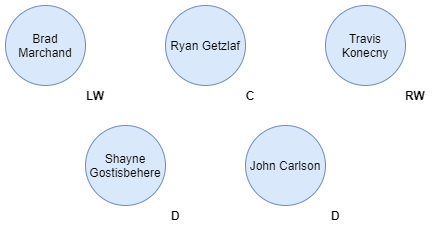